# 03 — CMB-inspired ML Example: Classifying Power Spectra

In this notebook we connect the general ML ideas to a simple, physics-motivated task:

> **Classify toy "CMB-like" power spectra as either ΛCDM-like or having an extra feature.**

We will:

1. Generate a synthetic dataset of **binned angular power spectra**.
2. Define two classes:
   - **Class 0**: smooth, "ΛCDM-like" spectra.
   - **Class 1**: same baseline but with a **localized oscillatory feature**.
3. Train a **supervised classifier** on these spectra.
4. Inspect **which multipole ranges** are most important for the classification.
5. Discuss **interpretability** and **limitations** (simulation vs real data).

The goal is *not* realism, but to have a clean, visual example that feels like CMB analysis while illustrating core ML concepts.


In [1]:
import numpy as np
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import (
    accuracy_score,
    classification_report,
    roc_auc_score,
)

rng = np.random.default_rng(42)

plt.rcParams["figure.figsize"] = (7, 5)
plt.rcParams["axes.grid"] = True

## A toy model of CMB-like power spectra

We will work with a very simplified picture:

- We define multipoles $\ell = 2, \dots, \ell_\text{max}$.
- We build a **smooth baseline spectrum** $C_\ell^{\text{base}}$ that vaguely resembles a CMB spectrum
  (strong first peak, decaying tail, some broad peak structure).
- For **feature models**, we multiply this baseline by a **localized oscillatory bump** in $\ell$-space.

Then we:

- **bin** the $C_\ell$ values into bandpowers (like experimental binning),
- add **noise** to mimic cosmic variance / experimental uncertainty,
- treat each binned spectrum as a feature vector for a classifier.

This is intentionally toy-ish but captures the right *kind* of structure:
localized features on top of an otherwise smooth spectrum.


In [2]:
# Multipole grid
ell_min, ell_max = 2, 2000
ells = np.arange(ell_min, ell_max + 1)

len(ells)

1999

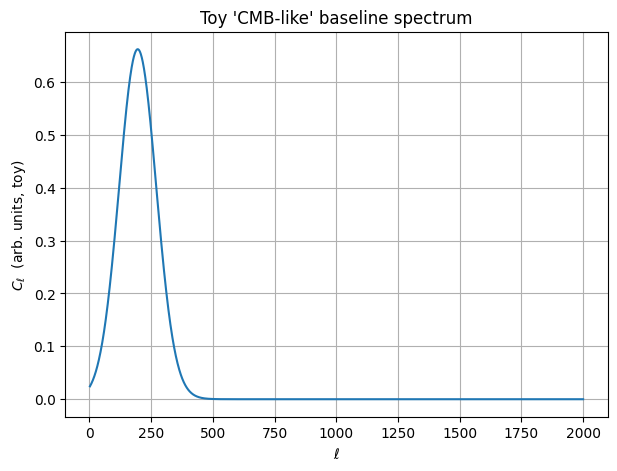

In [3]:
def baseline_cl(ell, A=1.0, l_peak=220.0, width_peak=80.0, damping_scale=1500.0):
    """
    Toy 'CMB-like' angular power spectrum:
    - broad acoustic peak
    - decaying tail
    """
    # Broad first peak
    peak = np.exp(-0.5 * ((ell - l_peak) / width_peak) ** 2)
    # Some gentle wiggles (very crude multi-peak feel)
    wiggles = 0.4 * np.cos(ell / 150.0) + 0.6
    # Damping at high ell
    damping = np.exp(-(ell / damping_scale) ** 2)
    cl = A * peak * wiggles * damping
    # Avoid zeros
    return cl + 1e-8

cl_base = baseline_cl(ells)
plt.plot(ells, cl_base)
plt.xlabel(r"$\ell$")
plt.ylabel(r"$C_\ell$  (arb. units, toy)")
plt.title("Toy 'CMB-like' baseline spectrum")
plt.show()

In [4]:
def add_local_feature(cl, ell, amp=0.25, l0=500.0, width=80.0, freq=0.15):
    """
    Multiply baseline Cl by a localized oscillatory feature around ell ~ l0.

    cl_new = cl * (1 + amp * bump),
    where bump is a Gaussian envelope times a sinusoid in ell.
    """
    envelope = np.exp(-0.5 * ((ell - l0) / width) ** 2)
    oscill = np.sin(freq * (ell - l0))
    bump = envelope * oscill
    return cl * (1.0 + amp * bump)

cl_feat = add_local_feature(cl_base, ells, amp=0.3, l0=500.0, width=70.0, freq=0.18)



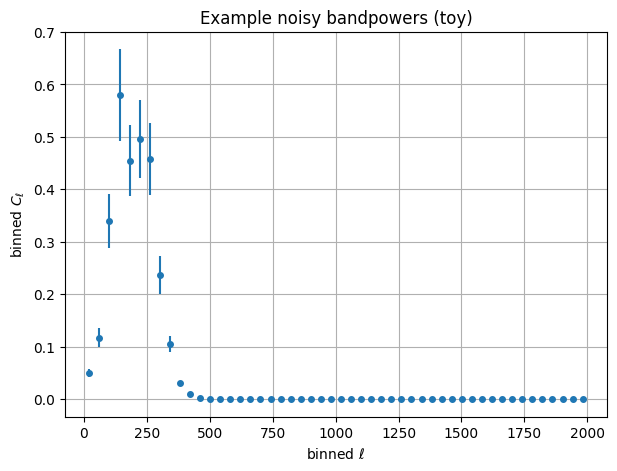

In [5]:
def bin_cl(ell, cl, nbins=50):
    """
    Bin C_ell into nbins approximately equal in ell.
    Returns bandpower centers and averaged C_ell in each bin.
    """
    indices = np.array_split(np.arange(len(ell)), nbins)
    cl_binned = np.array([cl[idx].mean() for idx in indices])
    ell_centers = np.array([ell[idx].mean() for idx in indices])
    return ell_centers, cl_binned

def noisy_bandpower_realization(ell, cl_theory, frac_noise=0.1, nbins=50):
    """
    From a theoretical spectrum, create a noisy binned spectrum.
    frac_noise is a fractional Gaussian noise level.
    """
    ell_c, cl_b = bin_cl(ell, cl_theory, nbins=nbins)
    noise = rng.normal(0.0, frac_noise * cl_b)
    cl_obs = cl_b + noise
    # Ensure positivity
    cl_obs = np.clip(cl_obs, 1e-8, None)
    return ell_c, cl_obs

# Quick test
ell_c_test, cl_obs_test = noisy_bandpower_realization(ells, cl_base, frac_noise=0.15)
plt.errorbar(ell_c_test, cl_obs_test, yerr=0.15*cl_obs_test, fmt="o", ms=4)
plt.xlabel(r"binned $\ell$")
plt.ylabel(r"binned $C_\ell$")
plt.title("Example noisy bandpowers (toy)")
plt.show()


In [7]:
N = 2000             #total number of spectra
nbins = 150           #bandpowers per spectrum
frac_noise = 0.02    #fractional noise level

X = []
y = []
ell_centers = None

for i in range(N):
    #Randomize some baseline parameters slightly
    A = rng.uniform(0.9, 1.1)
    l_peak = rng.uniform(200.0, 240.0)
    width_peak = rng.uniform(60.0, 100.0)
    damping = rng.uniform(1300.0, 1800.0)
    
    cl0 = baseline_cl(ells, A=A, l_peak=l_peak,
                      width_peak=width_peak, damping_scale=damping)
    
    if rng.random() < 0.5:
        #Class 0: "ΛCDM-like" (no extra feature)
        cl_theory = cl0
        label = 0
    else:
        #Class 1: baseline + feature with random location & amplitude
        amp = rng.uniform(0.6, 1.2)
        l0_feat = rng.normal(600.0, 30.0)     # concentrated around ~600
        width_feat = rng.uniform(50.0, 80.0)
        freq_feat = rng.uniform(0.14, 0.20) 
        cl_featured = add_local_feature(
            cl0, ells,
            amp=amp, l0=l0_feat,
            width=width_feat, freq=freq_feat
        )
        cl_theory = cl_featured
        label = 1

    ell_c, cl_obs = noisy_bandpower_realization(
        ells, cl_theory, frac_noise=frac_noise, nbins=nbins
    )
    if ell_centers is None:
        ell_centers = ell_c  # store once

    X.append(cl_obs)
    y.append(label)

X = np.array(X)
y = np.array(y)


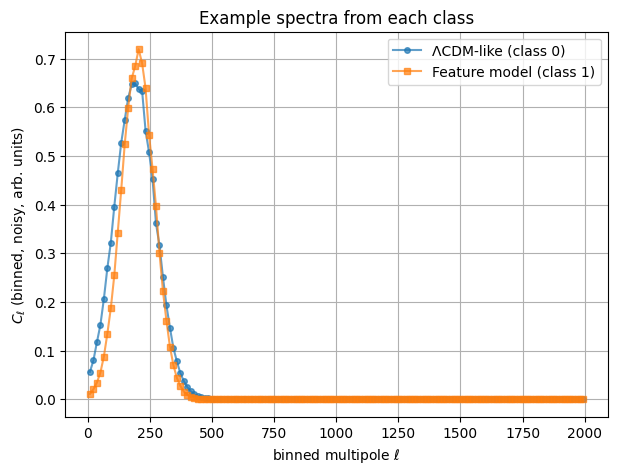

In [8]:
def plot_example_spectra(X, y, ell_c, n_per_class=3):
    plt.figure(figsize=(7, 5))
    classes = [0, 1]
    labels = ["ΛCDM-like (class 0)", "Feature model (class 1)"]
    markers = ["o", "s"]

    for cls, lab, mk in zip(classes, labels, markers):
        idx = np.where(y == cls)[0]
        idx = rng.choice(idx, size=min(n_per_class, 1), replace=False)
        for j in idx:
            plt.plot(ell_c, X[j], marker=mk, ms=4, alpha=0.7, label=lab if j == idx[0] else None)

    plt.xlabel(r"binned multipole $\ell$")
    plt.ylabel(r"$C_\ell$ (binned, noisy, arb. units)")
    plt.title("Example spectra from each class")
    plt.legend()
    plt.show()

plot_example_spectra(X, y, ell_centers)


In [9]:
import numpy as np
rng = np.random.default_rng(0)

ells = np.arange(2, 2000)

def baseline_cl(ells, A=1.0, ns=0.965):
    ell0 = 80.0
    cl = A * (ells / ell0) ** (ns - 1.0) * np.exp(-(ells / 1800.0) ** 2)
    return cl

def add_feature_simple(cl, ells, amp=0.05, ell_min=300, ell_max=700):
    """Very simple feature: boost power by (1+amp) in a contiguous ell range."""
    cl_feat = cl.copy()
    mask = (ells >= ell_min) & (ells <= ell_max)
    cl_feat[mask] *= (1.0 + amp)
    return cl_feat

def noisy_bandpowers(cl, frac_noise=0.05, nbins=30):
    indices = np.array_split(np.arange(len(cl)), nbins)
    bp = np.array([cl[idx].mean() for idx in indices])
    bp = bp * (1.0 + rng.normal(0.0, frac_noise, size=bp.size))
    return bp

def generate_dataset(N=3000, nbins=50):
    X, y = [], []
    for i in range(N):
        cl_base = baseline_cl(ells, A=1.0, ns=0.965)

        if rng.random() < 0.5:
            #Class 0: pure baseline
            cl = cl_base
            label = 0
        else:
            #Class 1: baseline with a big fat bump between ell=300 and 700
            cl = add_feature_simple(cl_base, ells, amp=0.01,
                                    ell_min=300, ell_max=700)
            label = 1

        bp = noisy_bandpowers(cl, frac_noise=0.01, nbins=nbins)
        X.append(np.log(bp + 1e-6))
        y.append(label)

    return np.array(X), np.array(y)

X, y = generate_dataset()
print("X shape:", X.shape)
print("Class counts:", np.unique(y, return_counts=True))


X shape: (3000, 50)
Class counts: (array([0, 1]), array([1525, 1475]))


In [10]:
X_train, X_val, y_train, y_val = train_test_split(
    X, y, test_size=0.3, random_state=45
)

X_train.shape, X_val.shape

((2100, 50), (900, 50))

## Supervised classification setup

We now have:

- Inputs: **binned spectra** $X \in \mathbb{R}^{N \times \\text{nbins}}$
- Labels:
  - 0 = "ΛCDM-like"
  - 1 = "feature model"

This is a classic **supervised classification** problem:

$
(x_i, y_i) \to f_\theta(x_i) \approx y_i
$

Our model will output a **probability** that a given spectrum belongs to class 1
(feature model). We will train the model by minimizing a **loss function**
(related to the negative log-likelihood for a Bernoulli / categorical model).

We start with a simple **logistic regression** classifier and then briefly look at
what features (multipole ranges) it finds important.


In [21]:
import tensorflow as tf
tf.keras.backend.clear_session()  #Clear previous models from memory

In [22]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense

input_dim = X_train.shape[1]

def make_cmb_classifier():
    model = Sequential([
        Dense(64, activation="relu", input_shape=(input_dim,)),
        Dense(1, activation="sigmoid")  #binary classification
    ])

    model.compile(
        optimizer=tf.keras.optimizers.Adam(learning_rate=1e-3),
        loss="binary_crossentropy",
        metrics=["accuracy"]
    )
    return model

model = make_cmb_classifier()
model.summary()


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense (Dense)                   │ (None, 64)             │         3,264 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 3,329 (13.00 KB)

 Trainable params: 3,329 (13.00 KB)

 Non-trainable params: 0 (0.00 B)

In [23]:
epochs = 200
batch_size = 32

history = model.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    epochs=epochs,
    batch_size=batch_size,
    verbose=1
)

print("Final training accuracy:", history.history["accuracy"][-1])
print("Final validation accuracy:", history.history["val_accuracy"][-1])

Epoch 1/200
66/66 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.5381 - loss: 0.6994 - val_accuracy: 0.5000 - val_loss: 0.6947
Epoch 2/200
66/66 ━━━━━━━━━━━━━━━━━━━━ 0s 781us/step - accuracy: 0.5324 - loss: 0.6910 - val_accuracy: 0.5000 - val_loss: 0.6900
Epoch 3/200
66/66 ━━━━━━━━━━━━━━━━━━━━ 0s 819us/step - accuracy: 0.5143 - loss: 0.6905 - val_accuracy: 0.5000 - val_loss: 0.6894
Epoch 4/200
66/66 ━━━━━━━━━━━━━━━━━━━━ 0s 751us/step - accuracy: 0.5262 - loss: 0.6894 - val_accuracy: 0.5289 - val_loss: 0.6883
Epoch 5/200
66/66 ━━━━━━━━━━━━━━━━━━━━ 0s 701us/step - accuracy: 0.5205 - loss: 0.6902 - val_accuracy: 0.5011 - val_loss: 0.6877
Epoch 6/200
66/66 ━━━━━━━━━━━━━━━━━━━━ 0s 671us/step - accuracy: 0.5186 - loss: 0.6880 - val_accuracy: 0.5000 - val_loss: 0.6918
Epoch 7/200
66/66 ━━━━━━━━━━━━━━━━━━━━ 0s 697us/step - accuracy: 0.5267 - loss: 0.6887 - val_accuracy: 0.5000 - val_loss: 0.6880
Epoch 8/200
66/66 ━━━━━━━━━━━━━━━━━━━━ 0s 650us/step - accuracy: 0.5800 - loss: 0.6874 - val_accura

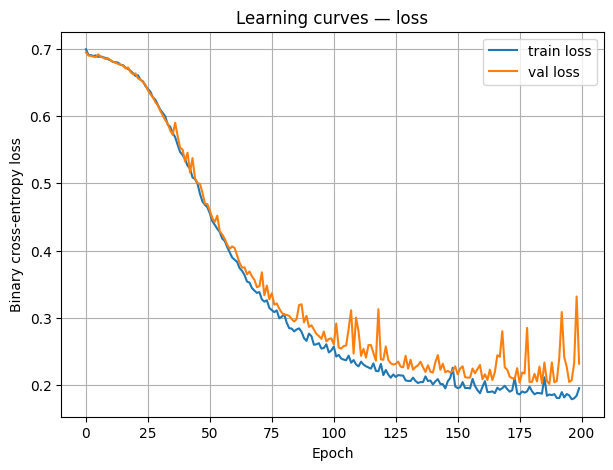

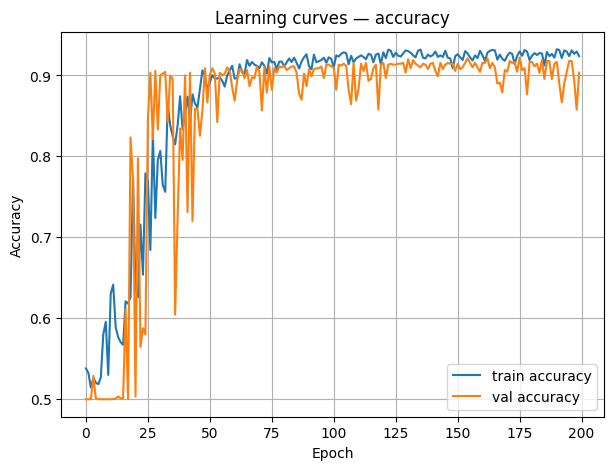

In [24]:
#Loss curves
plt.figure()
plt.plot(history.history["loss"], label="train loss")
plt.plot(history.history["val_loss"], label="val loss")
plt.xlabel("Epoch")
plt.ylabel("Binary cross-entropy loss")
plt.title("Learning curves — loss")
plt.legend()
plt.show()

#Accuracy curves
plt.figure()
plt.plot(history.history["accuracy"], label="train accuracy")
plt.plot(history.history["val_accuracy"], label="val accuracy")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.title("Learning curves — accuracy")
plt.legend()
plt.show()

Validation accuracy: 0.903


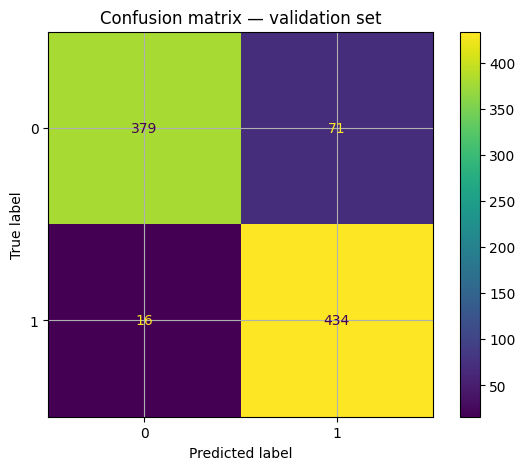

In [25]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
def predict_labels(model, X):
    proba = model.predict(X, verbose=0)
    return (proba > 0.5).astype(int).ravel()

y_val_pred = predict_labels(model, X_val)

acc_val = accuracy_score(y_val, y_val_pred)
print(f"Validation accuracy: {acc_val:.3f}")

cm = confusion_matrix(y_val, y_val_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot()
plt.title("Confusion matrix — validation set")
plt.show()


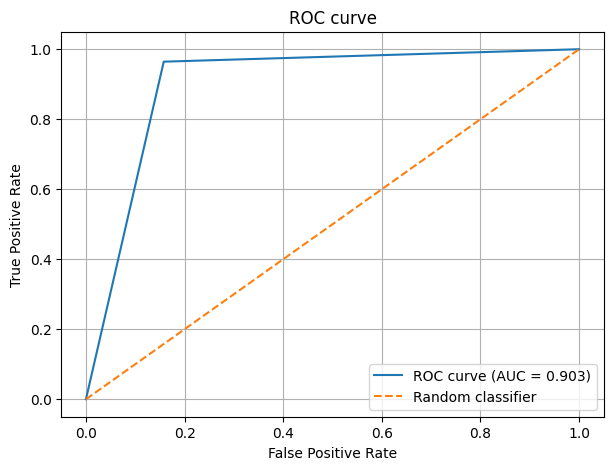

AUC: 0.9033333333333332


In [27]:
from sklearn.metrics import (
    confusion_matrix, ConfusionMatrixDisplay,
    accuracy_score, precision_score, recall_score, f1_score,
    roc_curve, roc_auc_score
)

fpr, tpr, roc_thresholds = roc_curve(y_val, y_val_pred)
auc = roc_auc_score(y_val, y_val_pred)

plt.plot(fpr, tpr, label=f"ROC curve (AUC = {auc:.3f})")
plt.plot([0, 1], [0, 1], "--", label="Random classifier")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC curve")
plt.legend()
plt.show()

print("AUC:", auc)